# Лабораторна робота 7. Методи кластеризації (навчання без учителя)

In [1]:
x_train_12 = [[30, 21], [12, 24], [23, 29], [23, 38], [32, 37], [22, 34], [21, 47], [ 5, 43], [ 5, 47]]
y_train_12 = [-1, -1, -1, -1,  1, -1,  1, -1, -1]

### Реалізація алгритму K-середніх

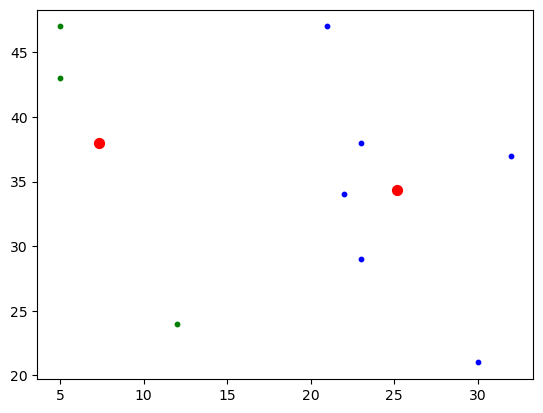

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Адаптация данных к формату исходного алгоритма
x = x_train_12

# Вычисление средних и дисперсий
M = np.mean(x, axis=0)
D = np.var(x, axis=0)

# Определение количества кластеров
K = len(np.unique(y_train_12))

# Генерация начальных центров кластеров
ma = [np.random.normal(M, np.sqrt(D / 10), 2) for n in range(K)]

# Функция для вычисления евклидовой метрики
ro = lambda x_vect, m_vect: np.mean((x_vect - m_vect) ** 2)

# Колорирование кластеров
COLORS = ('green', 'blue', 'brown', 'black')

# Инициализация графика
plt.ion()

n = 0
while n < 9:
    X = [[] for i in range(K)]

    for x_vect, y_label in zip(x, y_train_12):
        r = [ro(x_vect, m) for m in ma]
        X[np.argmin(r)].append(x_vect)

    ma = [np.mean(xx, axis=0) for xx in X]

    plt.clf()

    # Отображение кластеров
    for i in range(K):
        xx = np.array(X[i]).T
        plt.scatter(xx[0], xx[1], s=10, color=COLORS[i])

    # Отображение центров кластеров
    mx = [m[0] for m in ma]
    my = [m[1] for m in ma]
    plt.scatter(mx, my, s=50, color='red')

    plt.draw()
    plt.gcf().canvas.flush_events()

    n += 1

plt.ioff()
plt.show()

### Алгоритм DBSCAN

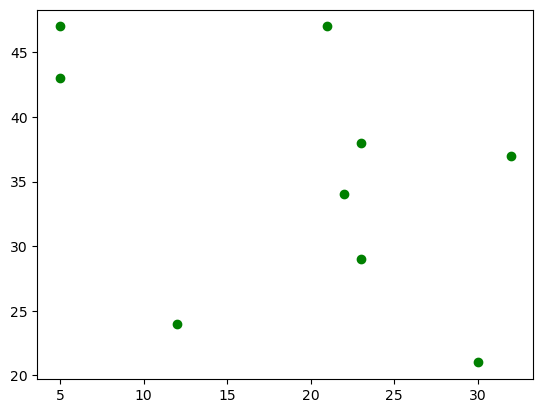

In [18]:
from itertools import cycle
from math import hypot
from numpy import random
import matplotlib.pyplot as plt


def dbscan_naive(P, eps, m, distance):
    NOISE = 0
    C = 0

    visited_points = set()
    clustered_points = set()
    clusters = {NOISE: []}

    def region_query(p):
        return [q for q in P if distance(p, q) < eps]

    def expand_cluster(p, neighbours):
        if C not in clusters:
            clusters[C] = []
        clusters[C].append(p)
        clustered_points.add(p)
        while neighbours:
            q = neighbours.pop()
            if q not in visited_points:
                visited_points.add(q)
                neighbourz = region_query(q)
                if len(neighbourz) > m:
                    neighbours.extend(neighbourz)
            if q not in clustered_points:
                clustered_points.add(q)
                clusters[C].append(q)
                if q in clusters[NOISE]:
                    clusters[NOISE].remove(q)

    for p in P:
        if p in visited_points:
            continue
        visited_points.add(p)
        neighbours = region_query(p)
        if len(neighbours) < m:
            clusters[NOISE].append(p)
        else:
            C += 1
            expand_cluster(p, neighbours)

    return clusters

# Розмір епсилон-околу
eps = 60    
# Мінімальна кількість об'єктів для повного епсилон-околу
m = 5       
x_train_12 = [(30, 21), (12, 24), (23, 29), (23, 38), (32, 37), (22, 34), (21, 47), (5, 43), (5, 47)]
clusters = dbscan_naive(x_train_12, eps, m, lambda x, y: hypot(x[0] - y[0], x[1] - y[1]))
for c, points in zip(cycle('bgrcmykgrcmykgrcmykgrcmykgrcmykgrcmyk'), clusters.values()):
    X = [p[0] for p in points]
    Y = [p[1] for p in points]
    plt.scatter(X, Y, c=c)
plt.show()

### Алгоритм DBSCAN засобами scikit-learn

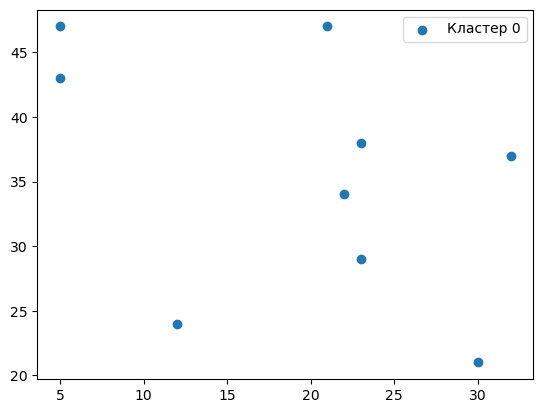

In [22]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Дані
P = np.array([(30, 21), (12, 24), (23, 29), (23, 38), (32, 37), (22, 34), (21, 47), (5, 43), (5, 47)])

# Розмір епсилон-околу
eps = 60    
# Мінімальна кількість об'єктів для повного епсилон-околу
m = 5   

# Використання алгоритму DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=m)
dbscan.fit(P)
labels = dbscan.labels_

# Вивід кластерів
unique_labels = np.unique(labels)
for label in unique_labels:
    if label == -1:
        plt.scatter(P[labels == label][:, 0], P[labels == label][:, 1], color='k', label='Шум')
    else:
        plt.scatter(P[labels == label][:, 0], P[labels == label][:, 1], label=f'Кластер {label}')

plt.legend()
plt.show()


### Алгоритм агломеративної ієрархічної кластеризації

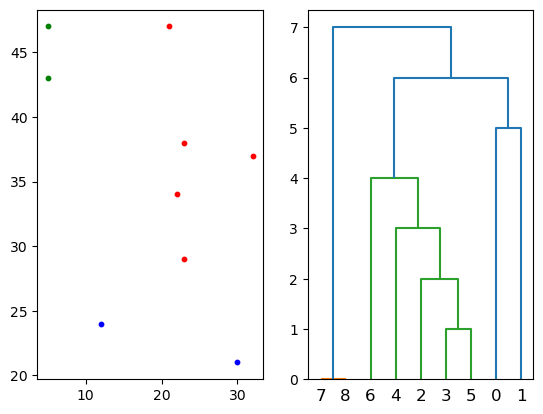

In [23]:
from itertools import cycle
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt


# функція для відображення дендрограми (взято з репозиторію sklearn)
def plot_dendrogram(model, **kwargs):

    # Діти ієрархічної кластеризації
    children = model.children_

    # Відстані між кожною парою дітей
    # Оскільки у нас немає цієї інформації, ми можемо використовувати рівномірну для відображення
    distance = np.arange(children.shape[0])

    # Кількість спостережень у кожному рівні кластеру
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Створення матриці зв'язків, а потім побудова дендрограми
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Побудова відповідної дендрограми
    dendrogram(linkage_matrix, **kwargs)


# вхідні зображення для кластеризації
x = np.array(x_train_12)

NC = 3      # максимальна кількість кластерів (кінцевих)

# агломеративна ієрархічна кластеризація
clustering = AgglomerativeClustering(n_clusters=NC, linkage="ward")
x_pr = clustering.fit_predict(x)

# відображення результату кластеризації та дендрограми
f, ax = plt.subplots(1, 2)
for c, n in zip(cycle('bgrcmykgrcmykgrcmykgrcmykgrcmykgrcmyk'), range(NC)):
    clst = x[x_pr == n].T
    ax[0].scatter(clst[0], clst[1], s=10, color=c)

plot_dendrogram(clustering, ax=ax[1])
plt.show()

## Контрольні питання

1. У чому полягає задача кластеризації та які її цілі?

Задача кластеризації полягає у групуванні об'єктів у наборі даних таким чином, щоб об'єкти в одній групі були схожі між собою, а об'єкти в різних групах були відмінні. Ціллю кластеризації є розділення набору даних на групи, які мають внутрішню схожість і зовнішню відмінність.
   
2. Які критерії використовуються для оцінки якості розбиття об'єктів на групи у задачі кластеризації?

 Серед критеріїв, що використовуються для оцінки якості розбиття включають метрики внутрішнього та зовнішнього зв'язку, індекс силуету, дисперсію, кількість кластерів, довжину периметра та інші.

3. Що таке задача часткового навчання в контексті кластеризації?
У чому полягаєЯка ідея алгоритму k-середніх (k-means)?
У чому полягаєновна ідея алгоритму DBSCANn.

Задача часткового навчання в контексті кластеризації виникає, коли у наявності є лише частина міток класів для об'єктів у наборі даних. У цьому випадку алгоритм кластеризації використовується для автоматичного групування об'єктів, для яких відомі мітки класів, а потім навчається модель класифікації на цих даних.

Ідея алгоритму k-середніх заключається в тому, що набір даних розділяється на k груп шляхом мінімізації середнього квадратичного відхилення між кожним об'єктом і центроїдом групи, до якої він належить. Це виконується через ітеративний процес, де кожен об'єкт призначається до найближчого центроїда, після чого обчислюються нові центроїди.

Ідея алгоритму DBSCAN заключається в використанні густини даних для виявлення кластерів. Він розшифровує кластери як області, в яких знаходиться велика кількість точок, розділених областями низької щільності.

4. Як можна скористатися засобами бібліотеки scikit-learn для реалізації алгоритму DBSCAN на Python?

Для реалізації алгоритму DBSCAN використовують клас DBSCAN з бібліотеки scikit-learn. Спочатку необхідно імпортувати клас DBSCAN з модуля sklearn.cluster. Потім треба використати метод fit_predict(), щоб виконати кластеризацію та повернути мітки кластерів для кожного об'єкта у наборі даних.